<a href="https://colab.research.google.com/github/sumanyurosha/hackathons/blob/master/Vehicle_Croping_Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# downloading the weights and config file for YOLOv3
!wget -c https://pjreddie.com/media/files/yolov3.weights
!wget -c https://raw.githubusercontent.com/arunponnusamy/object-detection-opencv/master/yolov3.cfg

--2020-06-22 09:51:48--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 248007048 (237M), 239815355 (229M) remaining [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M   158KB/s    in 28m 7s  

2020-06-22 10:19:57 (139 KB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2020-06-22 10:19:59--  https://raw.githubusercontent.com/arunponnusamy/object-detection-opencv/master/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



Basically I have three rules:
1. Area Rule
2. Class Rule
3. Confidence Rule

* Area Rule says, pick out the object with largest area.
* Class Rule says, pick out the object only from these classes (car, truck, bus).
* Confidence Rule says, pick out the object with highest Confidence.


The problem is based around vehicle classification, So out main point of discussion should be the Vehicle, right? YES!

1. So it must have the largest area in the picture,
2. and it must have the highest Confidence in the picture,
3. and it must be the only object in the picture.


** But the above three assumptions are only valid for ideal cases and this dataset is not at all ideal. **

There are images where we have more than one object in the picture
where we have more than one vehicle in the images


Do below things:

Make a pool of objects which belong to our selected classes only
and then choose the object with highest confidence.

There is one major issue about croping errors and that is mainly due to presence of multiple vehicles of same class where the vehicle with smaller area has more confidence, So I introduced another rule for this. 

If the area enclosed by the max confidence object divided by the area enclosed by the largest detected object is greater than 60% only then crop the photo otherwise keep the original photo.

Below imaeges are examples of some cases which I have tried to cover through above rules:

2146, 331, 104, 2290, 262, 335, 771, 971, 1853, 166, 10, 731, 150

2212, 524, 1210, 2341, 918, 2020, 1956, 1390, 389, 2093, 1829, 1999, 635, 1345, 7, 292, 1890, 755, 2299, 2054, 754, 1610(crop), 853(crop), 2054(crop), 
1107(crop), 2009(crop)

(crop) means images with cropping error before applying 60% rule.


In [62]:
import time
import numpy as np
import cv2

# store classes name
yolo_classes = [
'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


# generate different colors for different classes 
yolo_COLORS = np.random.uniform(0, 255, size=(len(yolo_classes), 3))

# function to get the output layer names 
# in the architecture
def get_output_layers(net):
    
    layer_names = net.getLayerNames()
    
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers

# function to draw bounding box on the detected object with class name
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(yolo_classes[class_id])

    color = yolo_COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

def round_off(x):

    if x < 0:
        return 0
    elif x > 224:
        return 224
    else:
        return round(x)


def crop_out(dirname, filename):

    start = time.time()
    # read input image
    read_file = os.path.join(dirname, filename)
    image = cv2.imread(read_file)

    Width = image.shape[1]
    Height = image.shape[0]

    # print('height:{} , width:{}'.format(Height, Width))
    scale = 0.00392

    # read pre-trained model and config file
    net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')

    # create input blob 
    blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

    # set input blob for the network
    net.setInput(blob)

    # run inference through the network
    # and gather predictions from output layers
    outs = net.forward(get_output_layers(net))

    # initialization
    class_ids = []
    confidences = []
    boxes = []
    conf_threshold = 0.5
    nms_threshold = 0.4

    # for each detetion from each output layer 
    # get the confidence, class id, bounding box params
    # and ignore weak detections (confidence < 0.5)
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * Width)
                center_y = int(detection[1] * Height)
                w = int(detection[2] * Width)
                h = int(detection[3] * Height)
                x = center_x - w / 2
                y = center_y - h / 2
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])


    # apply non-max suppression
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    # go through the detections remaining
    # after nms and choose the one with max area
    idx = -1
    max_area = 0.
    max_confidence = 0.
    conf_idx = -1
    expected_classes = ['car', 'bus', 'truck']

    for i in indices:
        i = i[0]
        box = boxes[i]
        _x = box[0]
        _y = box[1]
        _w = box[2]
        _h = box[3]
        area = _w * _h

        # Area rule
        if max_area < area :
            max_area = area
            x, y, w, h = _x, _y, _w, _h
            idx = i

        # Class Rule and Confidence Rule
        if yolo_classes[class_ids[i]] in expected_classes and max_confidence < confidences[i]:
            max_confidence = confidences[i]
            conf_idx = i
            c_x, c_y, c_w, c_h = _x, _y, _w, _h
            max_conf_area = area
        
        # print('area : {} for class: {} and confidence: {}'.format(area, yolo_classes[class_ids[i]], confidences[i]))

    # print('largest area : {}'.format(max_area))
    # if conf_idx != -1:
    #     print('{} class had the most confidence: {}'.format(
    #         yolo_classes[class_ids[conf_idx]], confidences[conf_idx]))
        
    #     draw_bounding_box(image, class_ids[conf_idx], confidences[conf_idx],
    #                       round_off(c_x), round_off(c_y), round_off(c_x + c_w),
    #                       round_off(c_y + c_h))

    crop = False
    if conf_idx != -1 and idx != -1 :
        if max_conf_area / max_area > 0.6 :
            crop = True
        
    if crop :
        image = image[round_off(c_y):round_off(c_y + c_h), round_off(c_x):round_off(c_x + c_w)]

    write_dir = '/content/drive/My Drive/Resources/Dataset/janata-hackathon/cropped-images'
    write_file = os.path.join(write_dir, filename)
    cv2.imwrite(write_file, image)

    end = time.time()
    print('image successfully cropped => {}, time taken {}s'.format(filename, end - start))

In [63]:
import os

image_dir = "/content/drive/My Drive/Resources/Dataset/janata-hackathon/images"
start = time.time()
for dirname, _, filenames in os.walk(image_dir):
    for filename in filenames:
        if (filename[filename.index('.'):] == '.jpg'):
            crop_out(dirname, filename)



end = time.time()
print('task completed in {}s'.format(end - start))

image successfully cropped => 585.jpg, time taken 2.7902770042419434s
image successfully cropped => 586.jpg, time taken 2.398998498916626s
image successfully cropped => 587.jpg, time taken 2.4086008071899414s
image successfully cropped => 588.jpg, time taken 2.421391725540161s
image successfully cropped => 589.jpg, time taken 2.4449355602264404s
image successfully cropped => 59.jpg, time taken 2.4053397178649902s
image successfully cropped => 590.jpg, time taken 2.413181781768799s
image successfully cropped => 591.jpg, time taken 2.4252610206604004s
image successfully cropped => 592.jpg, time taken 2.4030494689941406s
image successfully cropped => 593.jpg, time taken 2.4099526405334473s
image successfully cropped => 594.jpg, time taken 2.407703399658203s
image successfully cropped => 595.jpg, time taken 2.418118953704834s
image successfully cropped => 596.jpg, time taken 2.4043736457824707s
image successfully cropped => 597.jpg, time taken 2.3983492851257324s
image successfully cropped

In [61]:
dir = "/content/drive/My Drive/Resources/Dataset/janata-hackathon"
for dirname, _, filenames in os.walk(dir):
        print(dirname)

/content/drive/My Drive/Resources/Dataset/janata-hackathon
/content/drive/My Drive/Resources/Dataset/janata-hackathon/images
/content/drive/My Drive/Resources/Dataset/janata-hackathon/cropped-images


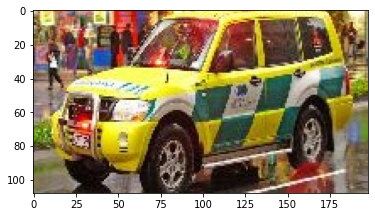

In [82]:
from skimage import io
import matplotlib.pyplot as plt

image = write_dir + '/166.jpg'
image = cv2.imread(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()